# Exploring Data Augmentation for Question Answering with T5
### Omar Kapur, Phillip Ng, Amber Rashid
#### W266, Summer 2021

In [1]:
## decide which size of T5 to use
t5_model = 't5-small'
#choose whether to save the model that will be trained
save_model = True
VERSION="augmented-drop-50percent-30"
#choose whether to load the weights of a previously trained model
load_model = False
load_version = ''
#choose whether to train the model
train_model = True
#choose whether to use a learning rate scheduler with warm-up & decay
use_learning_schedule = True

#choose whether to predict on train and/or dev sets
predict_train = False
predict_dev = True
#choose whether to save prediction results to pickle folder
save_results = True

#choose number of epochs
epochs = 30
#choose batch size
batch_size = 8
#choose dataset to use
dataset='augmented_drop' #acceptable values: drop, squad, hotpot_qa, augmented, augmented_drop
augmented_file = 'drop-augmented-50.pkl' #acceptable values: drop-augmented-5.pkl, drop-augmented-10.pkl, drop-augmented-25.pkl, drop-augmented-25.pkl

#choose whether to run a toy size dataset
run_toy = False
toy_size = 1000

#additional parameters
encoder_max_len = 512 #250
decoder_max_len = 54
buffer_size = 1000

#### Package installs

#### check gpu

In [2]:
!nvidia-smi

Fri Jul 30 09:27:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P8    49W / 420W |    490MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Download drop_eval module and set directories

https://github.com/allenai/allennlp-reading-comprehension/blob/master/allennlp_rc/eval/drop_eval.py

In [3]:
!wget https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py -O drop_eval.py
import os
def create_dir(d,verbose=False):
    if not os.path.exists(d):
        !mkdir -p $d    
        if verbose: print(f'created folder for {d}')
    else:
        if verbose: print(f'using existing folder for {d}\nCAUTION -- this run may overwrite existing data!')
    
#set directories
root_dir = './data'
data_dir = f"./data/{VERSION}/{t5_model}"
augmented_dir = f"{root_dir}/augmented-data"
results_dir = f"{data_dir}/results/"
log_dir = f"{data_dir}/experiments/logs"
save_dir = f"{data_dir}/experiments/models"
load_dir = f"{root_dir}/{load_version}/{t5_model}/experiments/models"

create_dir(root_dir)
create_dir(data_dir)
create_dir(augmented_dir)
create_dir(results_dir)
create_dir(log_dir)
create_dir(save_dir)

if load_model:
    assert os.path.exists(load_dir), 'Error - trying to load a model that doesnt exist'

--2021-07-30 09:27:15--  https://raw.githubusercontent.com/allenai/allennlp-reading-comprehension/master/allennlp_rc/eval/drop_eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11222 (11K) [text/plain]
Saving to: ‘drop_eval.py’

drop_eval.py        100%[===================>]  10.96K  --.-KB/s    in 0.004s  

2021-07-30 09:27:15 (2.63 MB/s) - ‘drop_eval.py’ saved [11222/11222]



#### load packages

In [4]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow.keras as keras
import drop_eval
import pandas as pd
import numpy as np
import json
from datasets import Dataset, load_dataset
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import re

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm,trange

%load_ext tensorboard

assert len(tf.config.list_physical_devices("GPU")) > 0, "No GPU found by Tensorflow"

if(run_toy): print(f'Running on {toy_size:,} records for development run')
    
!nvcc -V

2021-07-30 09:27:21.140206: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0


2021-07-30 09:27:22.379374: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-30 09:27:22.391100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-30 09:27:22.391853: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-30 09:27:22.391869: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-30 09:27:22.394055: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-30 09:27:22.394083: I tensorflow/stream_executor/plat

#### Define model class

In [5]:

class T5forDrop(TFT5ForConditionalGeneration):
    def __init__(self, *args, log_dir=None, cache_dir= None, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker= tf.keras.metrics.Mean(name='loss')
    
    @tf.function
    def train_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        with tf.GradientTape() as tape:
            outputs = self(x, training=True)
            loss = outputs[0]
            logits = outputs[1]
            loss = tf.reduce_mean(loss)
            
            grads = tape.gradient(loss, self.trainable_variables)
            
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        lr = self.optimizer._decayed_lr(tf.float32)
        
        self.loss_tracker.update_state(loss)        
        self.compiled_metrics.update_state(y, logits)
        metrics = {m.name: m.result() for m in self.metrics}
        metrics.update({'lr': lr})
        
        return metrics

    def test_step(self, data):
        x = data
        y = x["labels"]
        y = tf.reshape(y, [-1, 1])
        output = self(x, training=False)
        loss = output[0]
        loss = tf.reduce_mean(loss)
        logits = output[1]
        
        self.loss_tracker.update_state(loss)
        self.compiled_metrics.update_state(y, logits)
        return {m.name: m.result() for m in self.metrics}


#### Import model and tokenizer

In [6]:
tokenizer = T5Tokenizer.from_pretrained(t5_model)
#replace numbers with special tokens
numbers = {'additional_special_tokens':['1','2','3','4','5','6','7','8','9','0','<ss>','<sv>']}
num_tokens_added = tokenizer.add_special_tokens(numbers)


model = T5forDrop.from_pretrained(t5_model)

2021-07-30 09:27:28.369309: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-30 09:27:28.371775: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-30 09:27:28.374520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2021-07-30 09:27:28.374710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative valu

#### Import data

In [7]:
def make_toy(dataset,toy_size=1000):
    df = dataset.to_pandas()
    df = df.head(toy_size)
    return Dataset.from_pandas(df)

In [8]:
if dataset == "hotpot_qa":
    train_dataset_full = load_dataset(dataset,'distractor',split='train')
    
elif dataset == 'augmented':
    full_df = pd.read_pickle(augmented_dir+'/augmented_data.pkl')
    train_dataset_full = Dataset.from_pandas(full_df)
    
elif dataset == 'augmented_drop':
    aug_df = pd.read_pickle(augmented_dir+'/'+augmented_file)
    print('loaded augmented drop datafile: {}\n'.format(augmented_file))
    aug_df['source'] = 'augmented'
    drop_train_dataset = load_dataset('drop',split='train')
    drop_df = drop_train_dataset.to_pandas()
    drop_df['source'] = 'drop'
    train_df_full = pd.concat([drop_df,aug_df])
    train_dataset_full = Dataset.from_pandas(train_df_full)
    
elif dataset == 'drop':
    train_dataset_full = load_dataset(dataset,split='train')
else:
    train_dataset_full = load_dataset(dataset,split='train')

#always use drop validation dataset
valid_dataset_full = load_dataset('drop', split='validation')

print('Dataset features: ',train_dataset_full.features)

#reduce data to toy size if run_toy flag is set
if(run_toy):
    train_dataset = make_toy(train_dataset_full)
    valid_dataset = make_toy(valid_dataset_full)

else:
    train_dataset = train_dataset_full
    valid_dataset = valid_dataset_full
    
#check out one record
data = next(iter(valid_dataset))
print("\n\nExample data from the dataset: \n", data)

loaded augmented drop datafile: drop-augmented-50.pkl



Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)
Using custom data configuration default
Reusing dataset drop (/home/omar/.cache/huggingface/datasets/drop/default/0.1.0/393cc04823935c1302a6a7e380cdbe9f452d37858ea276409787c983748eae25)


Dataset features:  {'section_id': Value(dtype='string', id=None), 'query_id': Value(dtype='string', id=None), 'passage': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answers_spans': {'spans': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'types': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}, 'source': Value(dtype='string', id=None), 'index': Value(dtype='float64', id=None), 'context': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'qtype': Value(dtype='string', id=None), 'topic': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}


Example data from the dataset: 
 {'section_id': 'nfl_1184', 'query_id': 'f37e81fa-ef7b-4583-b671-762fc433faa9', 'passage': " Hoping to rebound from their loss to the Patriots, the Raiders stayed at home for a Week 16 duel with the Houston Texans.  Oakland would get the early lead in the first quarter as quarterback JaMa

#### set parameters

In [9]:
steps = int(np.ceil(len(train_dataset)/batch_size))
valid_steps = int(np.ceil(len(valid_dataset)/batch_size))
print('Training datset size: {:,} records'.format(len(train_dataset)))
print('Validation datset size: {:,} records'.format(len(valid_dataset)))
print('Batch size: {}'.format(batch_size))
print("Total Steps: {:,}".format(steps))
print("Total Validation Steps: {:,}".format(valid_steps))

Training datset size: 116,400 records
Validation datset size: 9,535 records
Batch size: 8
Total Steps: 14,550
Total Validation Steps: 1,192


#### Preprocess data

In [10]:
def encode_train(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):

    if dataset == 'drop':
        context = example['passage']
        question = example['question']

        answer = example['answers_spans']['spans']
        answer_type = example['answers_spans']['types']
    elif dataset == 'squad':
        context = example['context']
        question = example['question']
        
        answer = example['answers']['text']
        answer_type = 'text'
    elif dataset == 'hotpot_qa':
        context = ''
        for sentence in example["context"]["sentences"]:
            context += " ".join(sentence) + " "
        question = example['question']
        
        answer = [example['answer']]
        answer_type = 'text'    
    elif dataset == 'augmented':
        context = example['context']
        question = example['question']
        answer = [example['answer']]
        answer_type = example['qtype']
    elif dataset == 'augmented_drop':
        if(example['source'] == 'drop'):
            context = example['passage']
            question = example['question']
            answer = example['answers_spans']['spans']
            answer_type = example['answers_spans']['types']
        else:
            context = example['context']
            question = example['question']
            answer = [example['answer']]
            answer_type = example['qtype']
    
    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)}"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus}"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention,
                }
    return outputs

def encode_drop(example,
           encoder_max_len=encoder_max_len, decoder_max_len=decoder_max_len):

    context = example['passage']
    question = example['question']

    answer = example['answers_spans']['spans']
    answer_type = example['answers_spans']['types']

    question_plus = f"answer_me: {str(question)}"
    question_plus += f" context: {str(context)}"
    
    answer_plus = ', '.join([i for i in list(answer)])
    answer_plus = f"{answer_plus}"
    
    encoder_inputs = tokenizer(question_plus, truncation=True, 
                               return_tensors='tf', max_length=encoder_max_len,
                              pad_to_max_length=True)
    
    decoder_inputs = tokenizer(answer_plus, truncation=True, 
                               return_tensors='tf', max_length=decoder_max_len,
                              pad_to_max_length=True)
    
    input_ids = encoder_inputs['input_ids'][0]
    input_attention = encoder_inputs['attention_mask'][0]
    target_ids = decoder_inputs['input_ids'][0]
    target_attention = decoder_inputs['attention_mask'][0]
    
    outputs = {'input_ids':input_ids, 'attention_mask': input_attention, 
               'labels':target_ids, 'decoder_attention_mask':target_attention,
                }
    return outputs


def to_tf_dataset(dataset):
    '''convert from arrow to TF dataset'''
    
    columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']
    dataset.set_format(type='tensorflow', columns=columns)
    return_types = {'input_ids':tf.int32, 'attention_mask':tf.int32, 
                'labels':tf.int32, 'decoder_attention_mask':tf.int32,}
    return_shapes = {'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None]), 
                  'labels': tf.TensorShape([None]), 'decoder_attention_mask':tf.TensorShape([None]),}
    ds = tf.data.Dataset.from_generator(lambda : dataset, return_types, return_shapes)
    return ds

def create_dataset(dataset, cache_path=None, batch_size=batch_size, 
                   buffer_size= 1000, shuffling=True):
    '''returns a padded_batch tf dataset'''
    if cache_path is not None:
        dataset = dataset.cache(cache_path)        
    if shuffling:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.padded_batch(batch_size)
#     dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset



In [11]:
#Preprocess data

train_ds = train_dataset.map(encode_train)
tf_train_ds = to_tf_dataset(train_ds)
tf_train_ds = tf_train_ds.repeat(epochs)
tf_train_ds= create_dataset(tf_train_ds, batch_size=batch_size, 
                         shuffling=True, cache_path = None)


valid_ds = valid_dataset.map(encode_drop)
tf_valid_ds = to_tf_dataset(valid_ds)
tf_valid_ds = create_dataset(tf_valid_ds, batch_size=batch_size, 
                         shuffling=False, cache_path = None)

print('train dataset schema:')
tf_train_ds.element_spec
print('dev dataset schema:')
tf_valid_ds.element_spec

/home/omar/miniconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



train dataset schema:
dev dataset schema:


{'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'labels': TensorSpec(shape=(None, None), dtype=tf.int32, name=None),
 'decoder_attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}

#### Callbacks and checkpoints

In [12]:
# Learning Rate Schedule to input into CustomLearningRateScheduler()
def lr_schedule(training_steps, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if training_steps < __TOTAL_WARM_UP_STEPS:
        # print("\nWARM UP: Using Increasing Linear Function at Training Step:{}".format(training_steps))
        lr = ((MAX_LR - START_LR)/__TOTAL_WARM_UP_STEPS) * training_steps + START_LR # y = (m)x + b
    else:
        __CURRENT_DECAY_STEP = training_steps - __TOTAL_WARM_UP_STEPS
        if DECAY == "ExponentialDecay":
            # print("\nDECAY: Using ExponentialDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = keras.optimizers.schedules.ExponentialDecay(
                  initial_learning_rate=MAX_LR,
                  decay_steps=__TOTAL_DECAY_STEPS,
                  decay_rate=END_LR/MAX_LR)
        elif DECAY == "PiecewiseConstantDecay":
            # print("\nDECAY: Using PiecewiseConstantDecay at Training Step:{}".format(training_steps))
            __CURRENT_DECAY_STEP = tf.Variable(__CURRENT_DECAY_STEP, trainable=False)
            __DECAY_FN = keras.optimizers.schedules.PiecewiseConstantDecay(
                  __BOUNDARIES, __VALUES)
        elif DECAY == "PolynomialDecay":
            # print("\nDECAY: Using PolynomialDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = tf.keras.optimizers.schedules.PolynomialDecay(
                  MAX_LR,
                  __TOTAL_DECAY_STEPS,
                  END_LR,
                  power=POWER)
        elif DECAY == "InverseTimeDecay":
            # print("DECAY: Using InverseTimeDecay at Training Step:{}".format(training_steps))
            __DECAY_FN = keras.optimizers.schedules.InverseTimeDecay(
                  MAX_LR, __TIME_DECAY, 1)
        else:
            print("Please Select a Decay Function")
            exit
        lr = __DECAY_FN(__CURRENT_DECAY_STEP)
    return lr

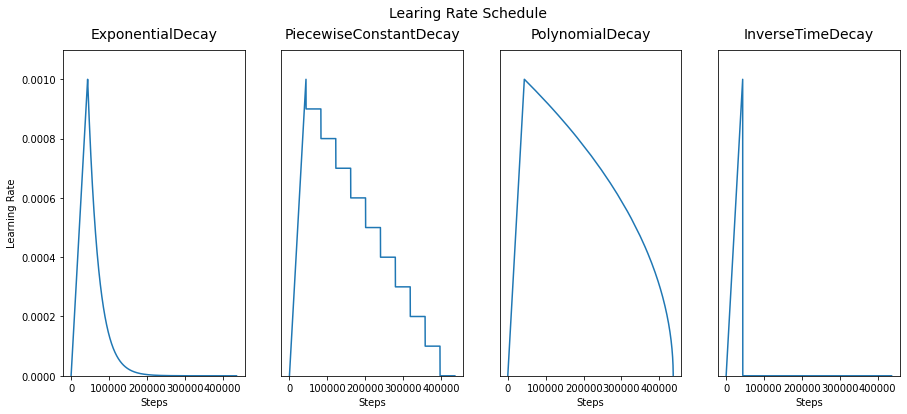

In [13]:
# Learning Rate Schedule Parameters
WARM_UP_FRACTION = 1/10 #The fraction of the training steps that will be ramping up linearly to the max LR
START_LR = 1e-7 # must be float
MAX_LR = 1e-3 # must be float
END_LR = 1e-9 # must be float
EPOCHS = epochs
STEPS_PER_EPOCH = steps
__TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
__TOTAL_WARM_UP_STEPS = __TOTAL_STEPS * WARM_UP_FRACTION
__TOTAL_DECAY_STEPS = __TOTAL_STEPS - __TOTAL_WARM_UP_STEPS
#--------------------------------------------------------------------------------------------
# Decay Parameters
# ExponentialDecay - None
# PiecewiseConstantDecay
NUM_BOUNDARIES = 10
__BOUNDARY_STEP = __TOTAL_DECAY_STEPS/NUM_BOUNDARIES
__BOUNDARIES = list(np.arange(0,__TOTAL_DECAY_STEPS,__BOUNDARY_STEP))
__PIECEWISE_STEP = (MAX_LR - END_LR)/(NUM_BOUNDARIES)
__VALUES = list(np.arange(MAX_LR,END_LR-__PIECEWISE_STEP,-__PIECEWISE_STEP))[:len(__BOUNDARIES)+1]
# if len(__BOUNDARIES)>
# PolynomialDecay
POWER = .5 # Must be > 1 to reach END_LR
#InverseTimeDecay
__TIME_DECAY = __TOTAL_DECAY_STEPS/(MAX_LR/END_LR-1)
#--------------------------------------------------------------------------------------------
# Initialize Graphing
decay_array = ["ExponentialDecay", "PiecewiseConstantDecay", "PolynomialDecay", "InverseTimeDecay"]
x = range(__TOTAL_STEPS)
fig, ax = plt.subplots(figsize=(15, 6),ncols=len(decay_array))
fig.suptitle(f'Learing Rate Schedule', fontsize=14)
ymax = max(START_LR,MAX_LR,END_LR)
ymax *= 1.1
ax[0].set_ylabel('Learning Rate')
for i,decay_type in enumerate(decay_array):
    DECAY = decay_type
    lr_values = []
    for step in x:
        lr_values.append(lr_schedule(step,0))
    ax[i].plot(x,lr_values)
    ax[i].set_title(decay_type, fontsize=14, pad=11)
    ax[i].set_xlabel('Steps')
    ax[i].set_ylim([0,ymax])
    if i > 0:
        ax[i].tick_params(which='both', left=False, labelleft=False)
plt.show()
#--------------------------------------------------------------------------------------------
# ACTION: Select Decay Type
DECAY = "PiecewiseConstantDecay" #["ExponentialDecay", "PiecewiseConstantDecay", "PolynomialDecay", "InverseTimeDecay"]

In [14]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.current_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        self.current_epoch += 1

    def on_batch_begin(self, batch_step, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        total_steps = batch_step + self.current_epoch * steps
        scheduled_lr = self.schedule(total_steps, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        # print("\nEpoch %05d: Learning rate is %6.4f." % (total_steps, scheduled_lr))

In [15]:
start_profile_batch = steps+10
stop_profile_batch = start_profile_batch + 100
profile_range = f"{start_profile_batch},{stop_profile_batch}"

log_path = log_dir + "/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                     update_freq=20,profile_batch=profile_range)

checkpoint_filepath = save_dir + "/" + "T5-{epoch:04d}-{val_loss:.4f}.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

callbacks = [tensorboard_callback, model_checkpoint_callback] 
if use_learning_schedule:
    callbacks.append(CustomLearningRateScheduler(lr_schedule))
metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5,name='accuracy') ]#[drop_eval.get_metrics]

2021-07-30 09:46:53.784273: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-30 09:46:53.784337: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2021-07-30 09:46:53.784430: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1611] Profiler found 1 GPUs
2021-07-30 09:46:53.785343: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64::/usr/local/cuda/lib64
2021-07-30 09:46:53.786966: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcupti.so
2021-07-30 09:46:54.021634: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2021-07-30 09:46:54.021765: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity bu

#### Compile and run model

In [16]:
optimizer = tf.keras.optimizers.Adam(START_LR, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model.compile(optimizer=optimizer, metrics=metrics)
model.summary()

Model: "t5for_drop"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared (TFSharedEmbeddings)  multiple                  16449536  
_________________________________________________________________
encoder (TFT5MainLayer)      multiple                  18881280  
_________________________________________________________________
decoder (TFT5MainLayer)      multiple                  25175808  
Total params: 60,506,626
Trainable params: 60,506,624
Non-trainable params: 2
_________________________________________________________________


In [17]:
if load_model:
    model.load_weights(load_dir+'/tf_model.h5')
    print(f'Model loaded from {load_dir}')

In [18]:
%tensorboard --logdir $log_dir

In [19]:
if train_model:
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
    model.fit(tf_train_ds, epochs=epochs, steps_per_epoch=steps, callbacks=callbacks, 
              validation_data=tf_valid_ds, validation_steps=valid_steps,verbose=1)
    if(save_model):
        model.save_pretrained(save_dir)
        print('Training complete, model saved')

Epoch 1/30


2021-07-30 09:47:05.326591: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-30 09:47:05.602873: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3504000000 Hz


14550/14550 [==============================] - 1456s 99ms/step - accuracy: 0.9746 - loss: 0.3038 - lr: 1.6675e-04 - val_accuracy: 0.9560 - val_loss: 0.5362


Epoch 2/30
    9/14550 [..............................] - ETA: 23:02 - accuracy: 0.9920 - loss: 0.0727 - lr: 3.3349e-04

2021-07-30 10:11:37.743419: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2021-07-30 10:11:37.743437: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


  110/14550 [..............................] - ETA: 25:22 - accuracy: 0.9928 - loss: 0.0778 - lr: 3.3465e-04

2021-07-30 10:11:48.475104: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-07-30 10:11:48.478973: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1743] CUPTI activity buffer flushed
2021-07-30 10:11:49.472297: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 269407 callback api events and 271587 activity events. 
2021-07-30 10:11:52.856162: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


14550/14550 [==============================] - 1463s 101ms/step - accuracy: 0.9920 - loss: 0.0747 - lr: 5.0005e-04 - val_accuracy: 0.9546 - val_loss: 0.5315


Epoch 3/30
14550/14550 [==============================] - 1451s 100ms/step - accuracy: 0.9922 - loss: 0.0738 - lr: 8.3335e-04 - val_accuracy: 0.9575 - val_loss: 0.5395
Epoch 4/30
14550/14550 [==============================] - 1478s 102ms/step - accuracy: 0.9925 - loss: 0.0720 - lr: 9.0001e-04 - val_accuracy: 0.9600 - val_loss: 0.4934


Epoch 5/30
14550/14550 [==============================] - 1476s 101ms/step - accuracy: 0.9930 - loss: 0.0680 - lr: 9.0000e-04 - val_accuracy: 0.9602 - val_loss: 0.5032
Epoch 6/30
14550/14550 [==============================] - 1476s 101ms/step - accuracy: 0.9934 - loss: 0.0653 - lr: 8.7000e-04 - val_accuracy: 0.9617 - val_loss: 0.6062
Epoch 7/30
14550/14550 [==============================] - 1476s 101ms/step - accuracy: 0.9938 - loss: 0.0614 - lr: 8.0000e-04 - val_accuracy: 0.9587 - val_loss: 0.5716
Epoch 8/30
14550/14550 [==============================] - 1476s 101ms/step - accuracy: 0.9941 - loss: 0.0593 - lr: 8.0000e-04 - val_accuracy: 0.9649 - val_loss: 0.5642
Epoch 9/30
14550/14550 [==============================] - 1476s 101ms/step - accuracy: 0.9944 - loss: 0.0570 - lr: 7.4000e-04 - val_accuracy: 0.9654 - val_loss: 0.6160
Epoch 10/30
14550/14550 [==============================] - 1483s 102ms/step - accuracy: 0.9948 - loss: 0.0544 - lr: 7.0000e-04 - val_accuracy: 0.9670 - val_loss

#### Predict & Evaluate

In [20]:
def batch_predict(ds,model,tokenizer):
    preds = []

    with tqdm(total=batch_size*len(list(ds.as_numpy_iterator()))) as bar:
        for batch in ds:
            input_ids = batch['input_ids']
            output = model.generate(input_ids)

            for i in range(output.shape[0]):
                single_pred = tokenizer.decode(output[i])
                single_pred = single_pred.replace('<pad>','')
                single_pred = single_pred.replace('</s>','')
                single_pred = single_pred.strip()
                single_pred = re.sub(r'(\d)\s+(\d)', r'\1\2', single_pred)
                single_pred = re.sub(r'(\d)\s+(\d)', r'\1\2', single_pred)
                preds.append(single_pred)
                bar.update(1)
    return preds

def evaluate(df,ds_type='train'):
    EM = []
    F1 = []
    
    if ds_type == 'train':
        ds = dataset
    else:
        ds = 'drop'
        
    if ds == 'drop': 
        col = 'answers_spans'
        gold_col = 'spans'
    elif ds == 'hotpot_qa':
        col = 'answer'
        gold_col = ''
    elif ds == 'augmented':
        col = 'answer'
    else:
        col = 'answers'
        gold_col = 'text'
    for predicted,gold in tqdm(zip(df['predicted'],df[col])):

        best_EM = 0
        best_F1 = 0
        if (ds_type == 'train') and ((dataset == 'hotpot_qa') or (dataset == 'augmented')):
            metrics = drop_eval.get_metrics(predicted=predicted,gold=gold)
            best_EM = metrics[0]
            best_F1 = metrics[1]
            
        else:
            for potential_answer in gold[gold_col]:
                metrics = drop_eval.get_metrics(predicted=predicted,gold=potential_answer)

                if metrics[1] > best_F1:
                    best_EM = metrics[0]
                    best_F1 = metrics[1]

        EM.append(best_EM)
        F1.append(best_F1)
        
    df['EM'] = EM
    df['F1'] = F1
    
    print('Exact Match: {:0.4f}, F1: {:0.4f}'.format(df.EM.mean(),df.F1.mean()))
    return df


In [21]:
if predict_train:
    print('Making Train Predictions...')
    preds = batch_predict(ds=tf_train_ds,model=model,tokenizer=tokenizer)
    train_df = train_dataset.to_pandas()
    assert len(train_df) == len(preds), "count mismatch, something went wrong"
    train_df['predicted'] = preds
    print('Evaluating Train Predictions...')
    train_df = evaluate(train_df,ds_type='train')
    if save_results:
        train_df.to_pickle(results_dir+'{}_train'.format(dataset)+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the training data saved to:\n',results_dir)
    
if predict_dev:
    print('Making Dev Predictions...')
    preds = batch_predict(ds=tf_valid_ds,model=model,tokenizer=tokenizer)
    valid_df = valid_dataset.to_pandas()
    valid_df['predicted'] = preds
    assert len(valid_df) == len(preds), "count mismatch, something went wrong"
    print('Evaluating Dev Predictions...')
    valid_df = evaluate(valid_df,ds_type='valid')
    if save_results:
        valid_df.to_pickle(results_dir+'{}_validation'.format(VERSION)+datetime.datetime.now().strftime('%H%M-%h%d')+'.pkl')
        print('results for predictions on the validation data saved to:\n',results_dir)    
 

Making Dev Predictions...



Evaluating Dev Predictions...



Exact Match: 0.4535, F1: 0.5031
results for predictions on the validation data saved to:
 ./data/augmented-drop-50percent-30/t5-small/results/


In [22]:
def generate_answer(question,passage,model,tokenizer):
    
    input_text = f"question: {question} context: {passage} </s>"

    input_ids = tokenizer.encode(input_text,return_tensors="tf")  
    outputs = model.generate(input_ids)
    tokenizer.decode(outputs[0])
    ans = tokenizer.decode(outputs[0])
    ans = ans.replace('<pad>','')
    ans = ans.replace('</s>','')
    ans = ans.strip()
    ans = re.sub(r'(\d)\s+(\d)', r'\1\2', ans)
    ans = re.sub(r'(\d)\s+(\d)', r'\1\2', ans)
    return ans

## Knowledge test questions

In [23]:
print('TEST: Subtraction')
question='answer_me: What percentage of elephants do not like to eat walnuts?'
context = ' context: There are lots of elephants in the forest. They all like to eat different things. Sources say that 89.53% of elephants like to eat walnuts.'
true_ans = '10.47'

ans = generate_answer(question,context,model,tokenizer)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Subtraction


/home/omar/miniconda3/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:172: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(



True answer: 10.47
Predicted answer: 10.47


In [24]:
print('TEST: Subtraction')
question="answer_me: What percentage of Genghis Khan's troops survived?"
context = " context: Genghis Khan became fierce when they had lost the American Civil War against William the Conqueror. Leaders needed to be brave and help their troops win the victory. Sources say that 5.17% of Genghis Khan's troops died, after killing over triple as much of William the Conqueror's troops ."
true_ans = '94.83'

ans = generate_answer(question,context,model,tokenizer)
print(question)
print(context)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Subtraction
answer_me: What percentage of Genghis Khan's troops survived?
 context: Genghis Khan became fierce when they had lost the American Civil War against William the Conqueror. Leaders needed to be brave and help their troops win the victory. Sources say that 5.17% of Genghis Khan's troops died, after killing over triple as much of William the Conqueror's troops .

True answer: 94.83
Predicted answer: 94.83


In [25]:
print('TEST: Recall')
question='answer_me: What percentage of pandas like to eat fruit?'
context = ' context: Let us talk of pandas all over the world. They like to sleep for many hours. One study estimates that 79.29% of pandas like to eat fruit.'
true_ans = '79.29'

ans = generate_answer(question,context,model,tokenizer)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Recall

True answer: 79.29
Predicted answer: 79.29


In [26]:
print('TEST: Grouping')
question='answer_me: What was the Miami Heat season record?'
context = ' context: It was a painful season for the Miami Heat. The team played only 75 games this season due to covid cancellations. In the first half of the season, they won 33 and lost 5 games. But this was just the beginning. Many wrote off the Miami Heat, but they went on to win 16 more games. The team deserves some much-needed rest before next year begins.'
true_ans = '49-26'

ans = generate_answer(question,context,model,tokenizer)
print(question)
print(context)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Grouping
answer_me: What was the Miami Heat season record?
 context: It was a painful season for the Miami Heat. The team played only 75 games this season due to covid cancellations. In the first half of the season, they won 33 and lost 5 games. But this was just the beginning. Many wrote off the Miami Heat, but they went on to win 16 more games. The team deserves some much-needed rest before next year begins.

True answer: 49-26
Predicted answer: 49 -27


In [27]:
print('TEST: Sorting')
question='answer_me: What was the third largest species?'
context = ' context: Human are not alone on this earth, there exist various species of animals. Sources say that 27.22% of animals are pandas and 19.27% are monkeys all over the world, as the most populous species. Followed by giraffes making up 17.68%, and elephants making up 14.59%, respectively. Animals have characteristics which make them unique and are essential for their survival. Sources say that, there are only 12.35% of sharks and 8.87% of bears as the least populous species. Surprisingly, humans are animals too.'
true_ans = 'giraffes'

ans = generate_answer(question,context,model,tokenizer)
print(question)
print(context)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Sorting
answer_me: What was the third largest species?
 context: Human are not alone on this earth, there exist various species of animals. Sources say that 27.22% of animals are pandas and 19.27% are monkeys all over the world, as the most populous species. Followed by giraffes making up 17.68%, and elephants making up 14.59%, respectively. Animals have characteristics which make them unique and are essential for their survival. Sources say that, there are only 12.35% of sharks and 8.87% of bears as the least populous species. Surprisingly, humans are animals too.

True answer: giraffes
Predicted answer: giraffes


In [28]:
print('TEST: Or')
question='answer_me: Who won the game, the 49ers or the Saints?'
context = ' context: The two division leaders, the 49ers and the Saints, played the Sunday night game yesterday. The 49ers were the first to score, with 14 points, but an interception and a fumble led to the Saints scoring 14. There was heavy rainfall in the second quarter, but even still the Saints scored 7 points while the 49ers scored 6. An even third quarter resulted in both teams scoring 7. A final run of good luck helped the 49ers to score 3 more points. The winner of this game goes on to the playoffs.This was a great game!'
true_ans = '49ers'

ans = generate_answer(question,context,model,tokenizer)
print(question)
print(context)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Or
answer_me: Who won the game, the 49ers or the Saints?
 context: The two division leaders, the 49ers and the Saints, played the Sunday night game yesterday. The 49ers were the first to score, with 14 points, but an interception and a fumble led to the Saints scoring 14. There was heavy rainfall in the second quarter, but even still the Saints scored 7 points while the 49ers scored 6. An even third quarter resulted in both teams scoring 7. A final run of good luck helped the 49ers to score 3 more points. The winner of this game goes on to the playoffs.This was a great game!

True answer: 49ers
Predicted answer: 49 ers


In [29]:
print('TEST: Sort+')
question='answer_me: How much larger or smaller by percentage was the second largest species from the 3 smallest species combined?'
context = ' context: Animals are varied and diverse and can come from common ancestors as humans. One could say 41.32% of animals are butterflies and 21.23% are wolves in the jungle, as the most populous species. Followed by birds making up 17.05%, and rabbits making up 8.06%, respectively. Some animals can be domesticated. One could say, there are only 6.95% of cats and 5.38% of spiders as the least populous species. We should be living in harmony with other species.'
true_ans = '0.84'

ans = generate_answer(question,context,model,tokenizer)
print(question)
print(context)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Sort+
answer_me: How much larger or smaller by percentage was the second largest species from the 3 smallest species combined?
 context: Animals are varied and diverse and can come from common ancestors as humans. One could say 41.32% of animals are butterflies and 21.23% are wolves in the jungle, as the most populous species. Followed by birds making up 17.05%, and rabbits making up 8.06%, respectively. Some animals can be domesticated. One could say, there are only 6.95% of cats and 5.38% of spiders as the least populous species. We should be living in harmony with other species.

True answer: 0.84
Predicted answer: 1.17


In [30]:
print('TEST: Sort+')
question='answer_me: How many points did the Falcons score in their 4 lowest scoring games combined?'
context = ' context: The Falcons defeated the Lions to start the season, scoring 27 and only allowing 8. They went on to win against the 49ers 35-8 but then lost to the Patriots, scoring just 17. The Falcons would then defeat the Ravens (39-16), followed by another victory against the Raiders (25-19), and after a tragic missed kick, they fell to 49ers, 49 to 18. However they could not find any luck, as they would lose to the Green Bay Packers, 25 to 9, and again to the Lions, 52 to 4. Unfortunately they could not save their season, they lost 25-18 to their rivals, and 40-14 in the final game.'
true_ans = '44'

ans = generate_answer(question,context,model,tokenizer)
print(question)
print(context)
print('\nTrue answer: {}'.format(true_ans))
print('Predicted answer: {}'.format(ans))

TEST: Sort+
answer_me: How many points did the Falcons score in their 4 lowest scoring games combined?
 context: The Falcons defeated the Lions to start the season, scoring 27 and only allowing 8. They went on to win against the 49ers 35-8 but then lost to the Patriots, scoring just 17. The Falcons would then defeat the Ravens (39-16), followed by another victory against the Raiders (25-19), and after a tragic missed kick, they fell to 49ers, 49 to 18. However they could not find any luck, as they would lose to the Green Bay Packers, 25 to 9, and again to the Lions, 52 to 4. Unfortunately they could not save their season, they lost 25-18 to their rivals, and 40-14 in the final game.

True answer: 44
Predicted answer: 57
